# PREPROCESSING THE DATASET

In [11]:
import nilearn as nil
import nibabel as nib
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
from nilearn import plotting, surface, datasets, input_data, decomposition
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm # For having progressbar during loops
from nitime.timeseries import TimeSeries
from nitime.analysis import FilterAnalyzer
from sklearn.decomposition import PCA
from nilearn.connectome import ConnectivityMeasure
from matplotlib import colors
from matplotlib import patches
from pycirclize import Circos
import sys
import networkx as nx
import community as community_louvain
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Descovering the dataset

In [6]:
from nilearn import image

# Load the fMRI file for subject 1
fmri_img = image.load_img('/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/sub-01_task-fe_bold.nii.gz')

# Display image information
print(fmri_img.shape)  # Returns the shape (dimensions x, y, z, number of volumes)
print(fmri_img.header.get_zooms())
print(fmri_img.header.get_xyzt_units())

(128, 128, 36, 200)
(1.796875, 1.796875, 4.0, 3.000001)
('mm', 'sec')
<class 'numpy.ndarray'>
(128, 128, 36, 200)


# RESHAPE DEL DATASET

## load the brain mask and the atlas

In [12]:
mask_path='/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/functional_connectivity/data-2/group_mask/' # Path to the folder with the brain mask
filename='group_mask.nii.gz' # List of the subjects

mask_ = nib.load(mask_path+filename) # Load the nii.gz file of the subject
mask_header = mask_.header # Subject's header
mask_affine = mask_.affine # Subject's affine
mask = mask_.get_fdata() # Get the numpy version of the nii.gz file
print(mask.shape) # x*y*z*time
n_vox_mask = np.sum(mask==1) # Number of voxels within the mask

(52, 62, 52)


In [13]:
which_atlas = 'glasser' # Chose the atlas
main_path='/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/functional_connectivity/data-2/atlas/' # Path to the folder with the atlas
filename = 'glasser_MNI152NLin6Asym_labels_p20_resamp.nii.gz'
atlas_labels_file = 'glasser_labels.csv'
delimiter = ','

atlas_ = nib.load(main_path+'/'+which_atlas+'/'+filename) # Load the nii.gz file of the subject
atlas_header = atlas_.header # Subject's header
atlas_affine = atlas_.affine # Subject's affine
atlas = atlas_.get_fdata() # Get the numpy version of the nii.gz file
print(atlas.shape) # x*y*z*time

# Labels
atlas_labels = pd.read_csv(main_path+'/'+which_atlas+'/'+atlas_labels_file, delimiter=delimiter)
print(atlas.min(), atlas.max())

(52, 62, 52)
0.0 360.0


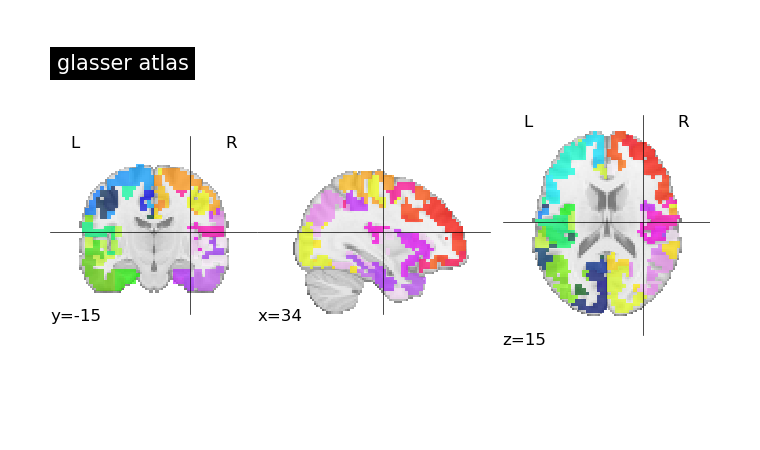

In [14]:
# Plot the atlas
plotting.plot_roi(atlas_, title=which_atlas+' atlas', display_mode='ortho')

## load the subjects

In [2]:
import nibabel as nib
import os

# Define the base directory where the subject data is stored
base_path = '/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/'

# Initialize a list to store data for all subjects
subjects_data = []

# Loop through subjects
for i in range(1, 41):
    # Format the subject ID as 'sub-01', 'sub-02', ..., 'sub-40'
    subj_id = f"sub-{i:02d}"
    
    # Construct the full path to the subject's fMRI file
    fmri_path = os.path.join(base_path, subj_id, 'func', f'{subj_id}_task-fe_bold.nii.gz')
    
    # Check if the fMRI file exists
    if os.path.exists(fmri_path):
        # Load the NIfTI image using nibabel
        sub_ = nib.load(fmri_path)
        
        # Create a dictionary with relevant subject information
        subject_dict = {
            'id': subj_id,                        # Subject ID
            'data': sub_.get_fdata(),             # 4D fMRI data as a NumPy array
            'header': sub_.header,                # Image header metadata
            'affine': sub_.affine,                # Affine transformation matrix
            'path': fmri_path                     # File path
        }
        
        # Print confirmation that the subject was loaded
        print(f"{subj_id} loaded, shape: {subject_dict['data'].shape}")
        
        # Append the subject's data to the list
        subjects_data.append(subject_dict)
    else:
        # Print a warning if the file was not found
        print(f"File not found: {fmri_path}")


sub-01 loaded, shape: (128, 128, 36, 200)
sub-02 loaded, shape: (128, 128, 36, 200)
sub-03 loaded, shape: (128, 128, 36, 200)
sub-04 loaded, shape: (128, 128, 36, 200)
sub-05 loaded, shape: (128, 128, 36, 200)
sub-06 loaded, shape: (128, 128, 36, 200)
sub-07 loaded, shape: (128, 128, 36, 200)
sub-08 loaded, shape: (128, 128, 36, 200)
sub-09 loaded, shape: (128, 128, 36, 200)
sub-10 loaded, shape: (128, 128, 36, 200)
sub-11 loaded, shape: (128, 128, 36, 200)
sub-12 loaded, shape: (128, 128, 36, 200)
sub-13 loaded, shape: (128, 128, 36, 200)
sub-14 loaded, shape: (128, 128, 36, 200)
sub-15 loaded, shape: (128, 128, 36, 200)
sub-16 loaded, shape: (128, 128, 36, 200)
sub-17 loaded, shape: (128, 128, 36, 200)
sub-18 loaded, shape: (128, 128, 36, 200)
sub-19 loaded, shape: (128, 128, 36, 200)
sub-20 loaded, shape: (128, 128, 36, 200)
sub-21 loaded, shape: (128, 128, 36, 200)
sub-22 loaded, shape: (128, 128, 36, 200)
sub-23 loaded, shape: (128, 128, 36, 200)
sub-24 loaded, shape: (128, 128, 3

## resamble the data to the dimention of the atlas 

In [4]:
from nilearn.image import resample_to_img

# Loop through each subject in the loaded subject data
for subject in subjects_data:
    # Resample the subject's functional image to match the resolution and space of the atlas
    resampled_img = resample_to_img(
        nib.Nifti1Image(subject['data'], subject['affine']),  # Original subject image
        atlas_                                                # Target image (e.g., an atlas)
    )
    
    save_path = os.path.join(base_path, subject['id'], 'func', f"{subject['id']}_resampled_fe.nii.gz" )
    
    # Save the resampled image to disk
    resampled_img.to_filename(save_path)

## SPLIT THE DATA 

In [1]:
from nilearn import image

# Load the fMRI file for subject 1
fmri_img = image.load_img('/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/sub-01_resampled_fe.nii.gz')

# Display image information
print(fmri_img.shape) 

(52, 62, 52, 200)


## creating the .tsv file 

In [15]:
base_path = '/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/'

subjects_data = []

for i in range(1, 41):
    subj_id = f"sub-{i:02d}"
    fmri_path = os.path.join(base_path, subj_id, 'func', f'{subj_id}_resampled_fe.nii.gz')
    
    
    if os.path.exists(fmri_path):
        sub_ = nib.load(fmri_path)
        subject_dict = {
            'id': subj_id,
            'data': sub_.get_fdata(),
            'header': sub_.header,
            'affine': sub_.affine,
            'path': fmri_path
        }
        print(f"{subj_id} loaded, shape: {subject_dict['data'].shape}")
        subjects_data.append(subject_dict)
    else:
        print(f"File non trovato: {fmri_path}")


sub-01 loaded, shape: (52, 62, 52, 200)
sub-02 loaded, shape: (52, 62, 52, 200)
sub-03 loaded, shape: (52, 62, 52, 200)
sub-04 loaded, shape: (52, 62, 52, 200)
sub-05 loaded, shape: (52, 62, 52, 200)
sub-06 loaded, shape: (52, 62, 52, 200)
sub-07 loaded, shape: (52, 62, 52, 200)
sub-08 loaded, shape: (52, 62, 52, 200)
sub-09 loaded, shape: (52, 62, 52, 200)
sub-10 loaded, shape: (52, 62, 52, 200)
sub-11 loaded, shape: (52, 62, 52, 200)
sub-12 loaded, shape: (52, 62, 52, 200)
sub-13 loaded, shape: (52, 62, 52, 200)
sub-14 loaded, shape: (52, 62, 52, 200)
sub-15 loaded, shape: (52, 62, 52, 200)
sub-16 loaded, shape: (52, 62, 52, 200)
sub-17 loaded, shape: (52, 62, 52, 200)
sub-18 loaded, shape: (52, 62, 52, 200)
sub-19 loaded, shape: (52, 62, 52, 200)
sub-20 loaded, shape: (52, 62, 52, 200)
sub-21 loaded, shape: (52, 62, 52, 200)
sub-22 loaded, shape: (52, 62, 52, 200)
sub-23 loaded, shape: (52, 62, 52, 200)
sub-24 loaded, shape: (52, 62, 52, 200)
sub-25 loaded, shape: (52, 62, 52, 200)


In [16]:
# Table of task conditions (onset, duration, emotion)
events_data = [
    (0,   30, 'calm'),
    (30,  30, 'white_noise'),
    (60,  30, 'afraid'),
    (90,  30, 'white_noise'),
    (120, 30, 'delighted'),
    (150, 30, 'white_noise'),
    (180, 30, 'depressed'),
    (210, 30, 'white_noise'),
    (240, 30, 'excited'),
    (270, 30, 'white_noise'),
    (300, 30, 'delighted'),
    (330, 30, 'white_noise'),
    (360, 30, 'depressed'),
    (390, 30, 'white_noise'),
    (420, 30, 'calm'),
    (450, 30, 'white_noise'),
    (480, 30, 'excited'),
    (510, 30, 'white_noise'),
    (540, 30, 'afraid'),
    (570, 30, 'white_noise'),
]

# Create DataFrame
events_df = pd.DataFrame(events_data, columns=["onset", "duration", "trial_type"])

# Base path for subjects
base_path = "/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/"

# Save .tsv files for all subjects
for i in range(1, 41):
    subj_id = f"sub-{i:02d}"
    tsv_path = os.path.join(base_path, subj_id, "func", f"{subj_id}_task-fe_events.tsv")
    events_df.to_csv(tsv_path, sep="\t", index=False)
    print(f"{tsv_path} salvato.")


/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/sub-01_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-02/func/sub-02_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-03/func/sub-03_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-04/func/sub-04_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-05/func/sub-05_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-06/func/sub-06_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-07/func/sub-07_task-fe_events.tsv salvato.
/Users/irenesilvestro/Desktop/quinto anno uni/computational ne

## split the data in 20 parts

In [19]:
# Global parameters
TR = 3
vol_per_clip = 30 // TR  # 10 volumes per segment

# Base path
base_path = "/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/"

# Loop over all subjects
for i in range(1, 41):
    subject_id = f"sub-{i:02d}"
    
    # Construct file paths
    func_path = os.path.join(base_path, subject_id, "func", f"{subject_id}_resampled_fe.nii.gz")
    tsv_path = os.path.join(base_path, subject_id, "func", f"{subject_id}_task-fe_events.tsv")
    output_dir = os.path.join(base_path, subject_id, "func", f"{subject_id}_splitted")
    
    # Check if files exist
    if not os.path.exists(func_path):
        print(f"[!] fMRI not found for {subject_id}")
        continue
    if not os.path.exists(tsv_path):
        print(f"[!] TSV not found for {subject_id}")
        continue

    # Create output folder if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Load the fMRI image
    img = nib.load(func_path)
    data = img.get_fdata()
    affine = img.affine
    header = img.header

    # Load events
    events = pd.read_csv(tsv_path, sep='\t')

    # Split and save each segment
    for j, row in events.iterrows():
        onset = int(row['onset'] // TR)  # from seconds to volumes
        label = row['trial_type']
        sub_data = data[..., onset:onset+vol_per_clip]
        
        new_img = nib.Nifti1Image(sub_data, affine, header)
        filename = f"{subject_id}_{j+1}_{label}.nii.gz"
        save_path = os.path.join(output_dir, filename)
        new_img.to_filename(save_path)
        print(f"{subject_id}: salvato {filename}")



sub-01: salvato sub-01_1_calm.nii.gz
sub-01: salvato sub-01_2_white_noise.nii.gz
sub-01: salvato sub-01_3_afraid.nii.gz
sub-01: salvato sub-01_4_white_noise.nii.gz
sub-01: salvato sub-01_5_delighted.nii.gz
sub-01: salvato sub-01_6_white_noise.nii.gz
sub-01: salvato sub-01_7_depressed.nii.gz
sub-01: salvato sub-01_8_white_noise.nii.gz
sub-01: salvato sub-01_9_excited.nii.gz
sub-01: salvato sub-01_10_white_noise.nii.gz
sub-01: salvato sub-01_11_delighted.nii.gz
sub-01: salvato sub-01_12_white_noise.nii.gz
sub-01: salvato sub-01_13_depressed.nii.gz
sub-01: salvato sub-01_14_white_noise.nii.gz
sub-01: salvato sub-01_15_calm.nii.gz
sub-01: salvato sub-01_16_white_noise.nii.gz
sub-01: salvato sub-01_17_excited.nii.gz
sub-01: salvato sub-01_18_white_noise.nii.gz
sub-01: salvato sub-01_19_afraid.nii.gz
sub-01: salvato sub-01_20_white_noise.nii.gz
sub-02: salvato sub-02_1_calm.nii.gz
sub-02: salvato sub-02_2_white_noise.nii.gz
sub-02: salvato sub-02_3_afraid.nii.gz
sub-02: salvato sub-02_4_whit

sub-10: salvato sub-10_14_white_noise.nii.gz
sub-10: salvato sub-10_15_calm.nii.gz
sub-10: salvato sub-10_16_white_noise.nii.gz
sub-10: salvato sub-10_17_excited.nii.gz
sub-10: salvato sub-10_18_white_noise.nii.gz
sub-10: salvato sub-10_19_afraid.nii.gz
sub-10: salvato sub-10_20_white_noise.nii.gz
sub-11: salvato sub-11_1_calm.nii.gz
sub-11: salvato sub-11_2_white_noise.nii.gz
sub-11: salvato sub-11_3_afraid.nii.gz
sub-11: salvato sub-11_4_white_noise.nii.gz
sub-11: salvato sub-11_5_delighted.nii.gz
sub-11: salvato sub-11_6_white_noise.nii.gz
sub-11: salvato sub-11_7_depressed.nii.gz
sub-11: salvato sub-11_8_white_noise.nii.gz
sub-11: salvato sub-11_9_excited.nii.gz
sub-11: salvato sub-11_10_white_noise.nii.gz
sub-11: salvato sub-11_11_delighted.nii.gz
sub-11: salvato sub-11_12_white_noise.nii.gz
sub-11: salvato sub-11_13_depressed.nii.gz
sub-11: salvato sub-11_14_white_noise.nii.gz
sub-11: salvato sub-11_15_calm.nii.gz
sub-11: salvato sub-11_16_white_noise.nii.gz
sub-11: salvato sub-1

sub-20: salvato sub-20_7_depressed.nii.gz
sub-20: salvato sub-20_8_white_noise.nii.gz
sub-20: salvato sub-20_9_excited.nii.gz
sub-20: salvato sub-20_10_white_noise.nii.gz
sub-20: salvato sub-20_11_delighted.nii.gz
sub-20: salvato sub-20_12_white_noise.nii.gz
sub-20: salvato sub-20_13_depressed.nii.gz
sub-20: salvato sub-20_14_white_noise.nii.gz
sub-20: salvato sub-20_15_calm.nii.gz
sub-20: salvato sub-20_16_white_noise.nii.gz
sub-20: salvato sub-20_17_excited.nii.gz
sub-20: salvato sub-20_18_white_noise.nii.gz
sub-20: salvato sub-20_19_afraid.nii.gz
sub-20: salvato sub-20_20_white_noise.nii.gz
sub-21: salvato sub-21_1_calm.nii.gz
sub-21: salvato sub-21_2_white_noise.nii.gz
sub-21: salvato sub-21_3_afraid.nii.gz
sub-21: salvato sub-21_4_white_noise.nii.gz
sub-21: salvato sub-21_5_delighted.nii.gz
sub-21: salvato sub-21_6_white_noise.nii.gz
sub-21: salvato sub-21_7_depressed.nii.gz
sub-21: salvato sub-21_8_white_noise.nii.gz
sub-21: salvato sub-21_9_excited.nii.gz
sub-21: salvato sub-21_

sub-29: salvato sub-29_20_white_noise.nii.gz
sub-30: salvato sub-30_1_calm.nii.gz
sub-30: salvato sub-30_2_white_noise.nii.gz
sub-30: salvato sub-30_3_afraid.nii.gz
sub-30: salvato sub-30_4_white_noise.nii.gz
sub-30: salvato sub-30_5_delighted.nii.gz
sub-30: salvato sub-30_6_white_noise.nii.gz
sub-30: salvato sub-30_7_depressed.nii.gz
sub-30: salvato sub-30_8_white_noise.nii.gz
sub-30: salvato sub-30_9_excited.nii.gz
sub-30: salvato sub-30_10_white_noise.nii.gz
sub-30: salvato sub-30_11_delighted.nii.gz
sub-30: salvato sub-30_12_white_noise.nii.gz
sub-30: salvato sub-30_13_depressed.nii.gz
sub-30: salvato sub-30_14_white_noise.nii.gz
sub-30: salvato sub-30_15_calm.nii.gz
sub-30: salvato sub-30_16_white_noise.nii.gz
sub-30: salvato sub-30_17_excited.nii.gz
sub-30: salvato sub-30_18_white_noise.nii.gz
sub-30: salvato sub-30_19_afraid.nii.gz
sub-30: salvato sub-30_20_white_noise.nii.gz
sub-31: salvato sub-31_1_calm.nii.gz
sub-31: salvato sub-31_2_white_noise.nii.gz
sub-31: salvato sub-31_

sub-39: salvato sub-39_13_depressed.nii.gz
sub-39: salvato sub-39_14_white_noise.nii.gz
sub-39: salvato sub-39_15_calm.nii.gz
sub-39: salvato sub-39_16_white_noise.nii.gz
sub-39: salvato sub-39_17_excited.nii.gz
sub-39: salvato sub-39_18_white_noise.nii.gz
sub-39: salvato sub-39_19_afraid.nii.gz
sub-39: salvato sub-39_20_white_noise.nii.gz
sub-40: salvato sub-40_1_calm.nii.gz
sub-40: salvato sub-40_2_white_noise.nii.gz
sub-40: salvato sub-40_3_afraid.nii.gz
sub-40: salvato sub-40_4_white_noise.nii.gz
sub-40: salvato sub-40_5_delighted.nii.gz
sub-40: salvato sub-40_6_white_noise.nii.gz
sub-40: salvato sub-40_7_depressed.nii.gz
sub-40: salvato sub-40_8_white_noise.nii.gz
sub-40: salvato sub-40_9_excited.nii.gz
sub-40: salvato sub-40_10_white_noise.nii.gz
sub-40: salvato sub-40_11_delighted.nii.gz
sub-40: salvato sub-40_12_white_noise.nii.gz
sub-40: salvato sub-40_13_depressed.nii.gz
sub-40: salvato sub-40_14_white_noise.nii.gz
sub-40: salvato sub-40_15_calm.nii.gz
sub-40: salvato sub-40_

## concatenate emotions for each subject 

In [2]:
from nilearn.image import concat_imgs

base_path = "/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA"

for i in range(1, 41):
    subj_id = f"sub-{i:02d}"
    path_1 = os.path.join(base_path, subj_id, "func", f"{subj_id}_splitted", f"{subj_id}_1_calm.nii.gz")
    path_15 = os.path.join(base_path, subj_id, "func", f"{subj_id}_splitted", f"{subj_id}_15_calm.nii.gz")

    concat_img = concat_imgs([path_1, path_15])

    output_dir = os.path.join(base_path, subj_id, "func", f"concatenate_emotions_{subj_id}")
    os.makedirs(output_dir, exist_ok=True)

    output_path = os.path.join(output_dir, f"calm_{subj_id}.nii.gz")
    concat_img.to_filename(output_path)


In [9]:
# Loop over all subjects (from 01 to 40)
for sub_id in range(1, 41):  # from 1 to 40 inclusive
    sub_str = f"{sub_id:02d}"  # Ensure the ID is in the format "01", "02", ..., "40"
    
    # Paths of the files to concatenate (for the specific subject)
    file_paths = [
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_9_excited.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_17_excited.nii.gz"
    ]
    
    # Load all NIfTI files
    imgs = [nib.load(f) for f in file_paths]
    
    # Extract data and concatenate along the time axis (last axis)
    data_concat = np.concatenate([img.get_fdata() for img in imgs], axis=3)
    
    # Use the affine and header from the first file as reference
    affine = imgs[0].affine
    header = imgs[0].header
    
    # Create the concatenated image
    concat_img = nib.Nifti1Image(data_concat, affine=affine, header=header)
    
    # Output directory
    output_dir = f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/concatenated_emotions_sub-{sub_str}"
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = os.path.join(output_dir, f"sub-{sub_str}_excited.nii.gz")
    
    # Save the file
    nib.save(concat_img, output_path)
    
    print(f"File salvato in: {output_path}")




File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/concatenated_emotions_sub-01/sub-01_excited.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-02/func/concatenated_emotions_sub-02/sub-02_excited.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-03/func/concatenated_emotions_sub-03/sub-03_excited.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-04/func/concatenated_emotions_sub-04/sub-04_excited.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-05/func/concatenated_emotions_sub-05/sub-05_excited.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-06/func/concatenated_emotions_sub-06/sub-06_excited.nii.g

## concatene all the emotions together and all the white noise together 

In [11]:
# Loop through all subjects (from 01 to 40)
for sub_id in range(1, 41):  # from 1 to 40 inclusive
    sub_str = f"{sub_id:02d}"  # Ensure the ID is in the format "01", "02", ..., "40"
    
    # Paths of the files to concatenate (for the specific subject)
    file_paths = [
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_1_calm.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_3_afraid.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_5_delighted.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_7_depressed.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_9_excited.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_11_delighted.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_13_depressed.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_15_calm.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_17_excited.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_19_afraid.nii.gz",
    ]
    
    # Load all NIfTI files
    imgs = [nib.load(f) for f in file_paths]
    
    # Extract data and concatenate along the time axis (last axis)
    data_concat = np.concatenate([img.get_fdata() for img in imgs], axis=3)
    
    # Use the affine and header from the first file as reference
    affine = imgs[0].affine
    header = imgs[0].header
    
    # Create the concatenated image
    concat_img = nib.Nifti1Image(data_concat, affine=affine, header=header)
    
    # Saving path
    output_dir = f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/concatenated_emotions_sub-{sub_str}"
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = os.path.join(output_dir, f"sub-{sub_str}_allemotions.nii.gz")
    
    # Save the file
    nib.save(concat_img, output_path)
    
    print(f"File salvato in: {output_path}")




File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/concatenated_emotions_sub-01/sub-01_allemotions.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-02/func/concatenated_emotions_sub-02/sub-02_allemotions.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-03/func/concatenated_emotions_sub-03/sub-03_allemotions.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-04/func/concatenated_emotions_sub-04/sub-04_allemotions.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-05/func/concatenated_emotions_sub-05/sub-05_allemotions.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-06/func/concatenated_emotions_sub-06/

In [3]:
for sub_id in range(1, 41):  
    sub_str = f"{sub_id:02d}"  
    
    # Paths of the files to concatenate (for the specific subject)
    file_paths = [
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_2_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_4_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_6_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_8_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_10_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_12_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_14_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_16_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_18_white_noise.nii.gz",
        f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/sub-{sub_str}_splitted/sub-{sub_str}_20_white_noise.nii.gz",
    ]
    
    # Load all NIfTI files
    imgs = [nib.load(f) for f in file_paths]
    
    
    # Extract the data and concatenate along the temporal axis (last axis)
    data_concat = np.concatenate([img.get_fdata() for img in imgs], axis=3)
       
    # Use the affine and header from the first file as reference
    affine = imgs[0].affine
    header = imgs[0].header
    
    
    # Create the concatenated image
    concat_img = nib.Nifti1Image(data_concat, affine=affine, header=header)
    
    output_dir = f"/Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-{sub_str}/func/concatenated_emotions_sub-{sub_str}"
    os.makedirs(output_dir, exist_ok=True)
    
    output_path = os.path.join(output_dir, f"sub-{sub_str}_whitenoise.nii.gz")
    

    nib.save(concat_img, output_path)
    
    print(f"File salvato in: {output_path}")
    

File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-01/func/concatenated_emotions_sub-01/sub-01_whitenoise.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-02/func/concatenated_emotions_sub-02/sub-02_whitenoise.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-03/func/concatenated_emotions_sub-03/sub-03_whitenoise.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-04/func/concatenated_emotions_sub-04/sub-04_whitenoise.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-05/func/concatenated_emotions_sub-05/sub-05_whitenoise.nii.gz
File salvato in: /Users/irenesilvestro/Desktop/quinto anno uni/computational neuroscience/PROGETTO/DATA/sub-06/func/concatenated_emotions_sub-06/sub-0